In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import random

In [2]:
# Ensure plots display inline in Jupyter Notebook
%matplotlib inline

In [3]:
# Paths to CSV files
ratings_path = "rating.csv"
movies_path = "movie.csv"

In [4]:
# Check if files exist
if not os.path.exists(ratings_path) or not os.path.exists(movies_path):
    raise FileNotFoundError("Make sure 'rating.csv' and 'movie.csv' exist in the same folder as this notebook.")

In [5]:
# Load datasets
df = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

In [6]:
# Encode movie IDs
movie_encoder = LabelEncoder()
df['movieId'] = movie_encoder.fit_transform(df['movieId'])

In [7]:
# User-movie interactions (for reference)
user_movie = df.groupby('userId')['movieId'].apply(list).to_dict()

In [8]:
# Define the Q-Learning-based Movie Recommender (Tabular Approach)
class MovieRecommenderQLearning:
    def __init__(self, df, state_size=5, gamma=0.99, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995, lr=0.1):
        self.df = df
        self.state_size = state_size  # Number of past movies to consider in the state
        self.movies = list(df['movieId'].unique())  # Actions (movies)
        self.action_size = len(self.movies)
        self.movie_to_idx = {movie: idx for idx, movie in enumerate(self.movies)}
        self.idx_to_movie = {idx: movie for movie, idx in self.movie_to_idx.items()}
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.lr = lr  # Learning rate

        # Initialize Q-table as a nested dictionary: {state: {action: q_value}}
        self.q_table = defaultdict(lambda: defaultdict(float))

        # Get average ratings for movies to use as rewards
        self.movie_ratings = df.groupby('movieId')['rating'].mean().to_dict()

    def get_state(self, history):
        # State is a tuple of the last `state_size` movies (padded with -1 if history is short)
        if len(history) < self.state_size:
            padded = [-1] * (self.state_size - len(history)) + history
        else:
            padded = history[-self.state_size:]
        return tuple(padded)  # Convert to tuple for hashability in Q-table

    def choose_action(self, state):
        # Epsilon-Greedy action selection
        if random.random() < self.epsilon:
            # Exploration: Choose a random movie
            action_idx = random.randint(0, self.action_size - 1)
        else:
            # Exploitation: Choose the movie with the highest Q-value
            q_values = self.q_table[state]
            if not q_values:  # If no Q-values for this state, choose randomly
                action_idx = random.randint(0, self.action_size - 1)
            else:
                action_idx = max(q_values, key=q_values.get, default=0)
        return action_idx

    def update_q_table(self, state, action, reward, next_state):
        # Q-Learning update rule: Q(s,a) = Q(s,a) + lr * (reward + gamma * max(Q(s',a')) - Q(s,a))
        current_q = self.q_table[state][action]
        next_q_values = self.q_table[next_state]
        max_next_q = max(next_q_values.values(), default=0.0) if next_q_values else 0.0
        self.q_table[state][action] = current_q + self.lr * (reward + self.gamma * max_next_q - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

In [9]:
# Simulate episodes and track metrics
def simulate_episodes_ql(qlearning, episodes=50, steps_per_episode=50):
    total_rewards = []
    coverages = []
    collisions = []
    revisits = []

    all_movies = list(df['movieId'].unique())
    total_movies = len(all_movies)

    for episode in range(episodes):
        # Reset for the episode
        user_id = np.random.choice(list(user_movie.keys()))
        user_movies = user_movie[user_id]
        history = [np.random.choice(user_movies)]  # Start with a random movie the user has watched
        state = qlearning.get_state(history)
        recommended_movies = set(history)
        recommendation_history = list(history)
        episode_reward = 0
        episode_collisions = 0

        # Simulate an episode of recommendations
        for step in range(steps_per_episode):
            # Choose an action (movie to recommend)
            action_idx = qlearning.choose_action(state)
            movie = qlearning.idx_to_movie[action_idx]

            # Compute reward (normalized rating)
            reward = qlearning.movie_ratings.get(movie, 3.0) - 3.0  # Normalize around 3.0
            episode_reward += reward

            # Collision: If the movie's average rating is below 3.0
            avg_rating = qlearning.movie_ratings.get(movie, 3.0)
            if avg_rating < 3.0:
                episode_collisions += 1

            # Track the recommendation
            recommended_movies.add(movie)
            recommendation_history.append(movie)

            # Get next state
            next_state = qlearning.get_state(recommendation_history)

            # Update Q-table
            qlearning.update_q_table(state, action_idx, reward, next_state)

            # Update state
            state = next_state

        # Decay epsilon
        qlearning.decay_epsilon()

        # Calculate metrics for the episode
        # Total Rewards
        total_rewards.append(episode_reward)

        # Coverage Percentage
        coverage = (len(recommended_movies) / total_movies) * 100
        coverages.append(coverage)

        # Collisions
        collisions.append(episode_collisions)

        # Revisits: Count how many times each movie was recommended, sum the revisits
        revisit_count = sum([recommendation_history.count(movie) - 1 for movie in set(recommendation_history)])
        revisits.append(revisit_count)

    return total_rewards, coverages, collisions, revisits

# Initialize the Q-Learning recommender
ql = MovieRecommenderQLearning(df, state_size=5)

# Run simulation to collect metrics
total_rewards, coverages, collisions, revisits = simulate_episodes_ql(ql)

In [10]:
# Compute efficiency metrics for bar charts
coverage_efficiency = np.mean(coverages) / 50  # Normalized by steps per episode
collision_rate = np.mean(collisions) / 50
obstacle_avoidance = 1 - collision_rate  # 1 - collision rate
revisit_rate = np.mean(revisits) / 50
exploration_efficiency = 1 / (1 + revisit_rate)

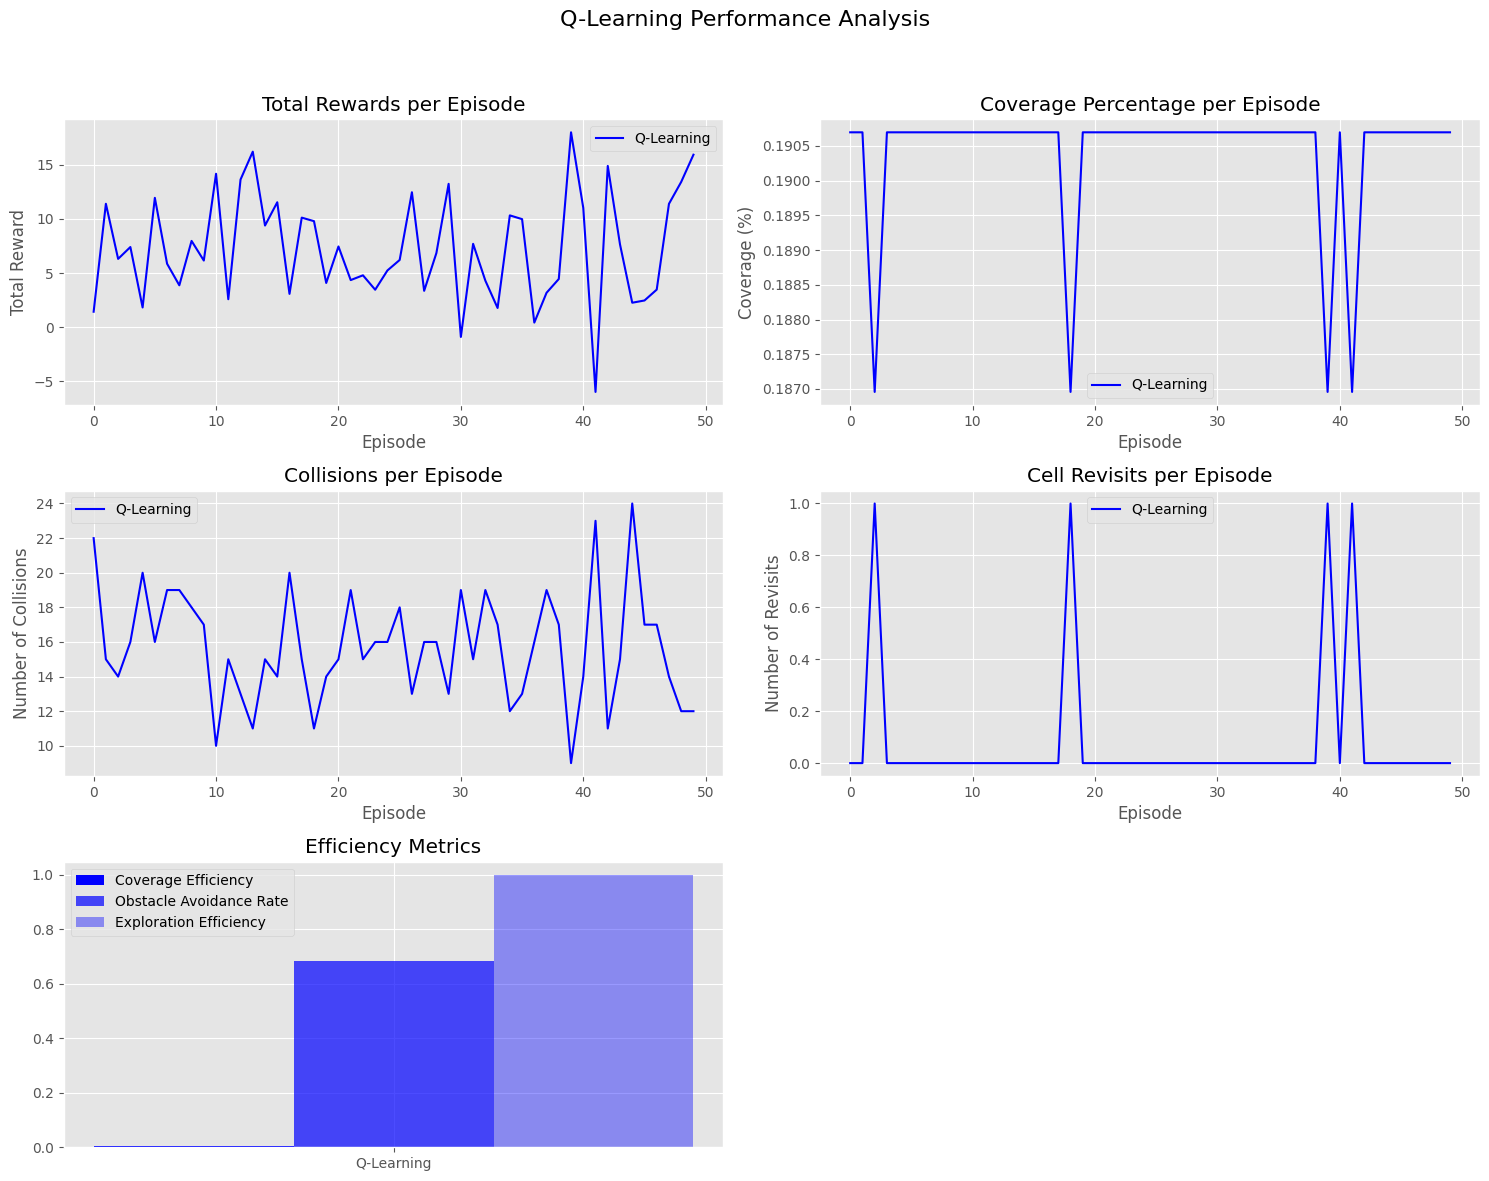

In [11]:
# Plotting
plt.style.use('ggplot')  # Use a built-in Matplotlib style

# Create a 3x2 subplot layout (last cell will be empty)
fig, axs = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle("Q-Learning Performance Analysis", fontsize=16)

# Plot 1: Total Rewards per Episode
axs[0, 0].set_title("Total Rewards per Episode")
axs[0, 0].plot(total_rewards, label="Q-Learning", color='blue')
axs[0, 0].set_xlabel("Episode")
axs[0, 0].set_ylabel("Total Reward")
axs[0, 0].legend()

# Plot 2: Coverage Percentage per Episode
axs[0, 1].set_title("Coverage Percentage per Episode")
axs[0, 1].plot(coverages, label="Q-Learning", color='blue')
axs[0, 1].set_xlabel("Episode")
axs[0, 1].set_ylabel("Coverage (%)")
axs[0, 1].legend()

# Plot 3: Collisions per Episode
axs[1, 0].set_title("Collisions per Episode")
axs[1, 0].plot(collisions, label="Q-Learning", color='blue')
axs[1, 0].set_xlabel("Episode")
axs[1, 0].set_ylabel("Number of Collisions")
axs[1, 0].legend()

# Plot 4: Cell Revisits per Episode
axs[1, 1].set_title("Cell Revisits per Episode")
axs[1, 1].plot(revisits, label="Q-Learning", color='blue')
axs[1, 1].set_xlabel("Episode")
axs[1, 1].set_ylabel("Number of Revisits")
axs[1, 1].legend()

# Plot 5: Bar Charts (Coverage Efficiency, Obstacle Avoidance Rate, Exploration Efficiency)
bar_width = 0.2
x = [0]  # Only one method (Q-Learning)
axs[2, 0].set_title("Efficiency Metrics")
axs[2, 0].bar([x[0] - bar_width], [coverage_efficiency], bar_width, label='Coverage Efficiency', color='blue')
axs[2, 0].bar(x, [obstacle_avoidance], bar_width, label='Obstacle Avoidance Rate', color='blue', alpha=0.7)
axs[2, 0].bar([x[0] + bar_width], [exploration_efficiency], bar_width, label='Exploration Efficiency', color='blue', alpha=0.4)
axs[2, 0].set_xticks(x)
axs[2, 0].set_xticklabels(["Q-Learning"])
axs[2, 0].legend()

# Hide the last subplot
axs[2, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [12]:
# Evaluation function: Hit Rate@k (adapted for Q-Learning)
def evaluate_model_ql(qlearning, top_k=5):
    hits = 0
    total = 0

    for user_id, group in df.groupby('userId'):
        movies_seq = group.sort_values('timestamp')['movieId'].tolist()

        for i in range(len(movies_seq) - 1):
            # Use the last movie as the starting point for the state
            history = [movies_seq[i]]
            state = qlearning.get_state(history)

            # Get the top-k recommended movies based on Q-values
            q_values = qlearning.q_table[state]
            if not q_values:  # If no Q-values, choose random actions
                recommended_indices = random.sample(range(qlearning.action_size), top_k)
            else:
                # Sort actions by Q-value and take the top k
                sorted_actions = sorted(q_values.items(), key=lambda x: x[1], reverse=True)
                recommended_indices = [action for action, _ in sorted_actions[:top_k]]
                # If fewer than top_k actions, fill with random ones
                if len(recommended_indices) < top_k:
                    remaining = top_k - len(recommended_indices)
                    available = set(range(qlearning.action_size)) - set(recommended_indices)
                    recommended_indices.extend(random.sample(list(available), remaining))

            recommended_ids = [qlearning.idx_to_movie[idx] for idx in recommended_indices]

            actual_next_movie = movies_seq[i + 1]
            if actual_next_movie in recommended_ids:
                hits += 1
            total += 1

    accuracy = hits / total if total > 0 else 0
    print(f"\n🎯 Hit Rate@{top_k}: {accuracy:.4f} ({hits} hits out of {total} transitions)")
    return accuracy

# Run evaluation
evaluate_model_ql(ql, top_k=5)

KeyboardInterrupt: 

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import random

In [15]:

# Ensure plots display inline in Jupyter Notebook
%matplotlib inline

In [16]:

# Paths to CSV files
ratings_path = "rating.csv"
movies_path = "movie.csv"

In [17]:
# Check if files exist
if not os.path.exists(ratings_path) or not os.path.exists(movies_path):
    raise FileNotFoundError("Make sure 'rating.csv' and 'movie.csv' exist in the same folder as this notebook.")

# Load datasets
df = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

In [18]:
# Encode movie IDs
movie_encoder = LabelEncoder()
df['movieId'] = movie_encoder.fit_transform(df['movieId'])

# User-movie interactions
user_movie = df.groupby('userId')['movieId'].apply(list).to_dict()

In [20]:
# Define MDP Model
class MovieRecommenderMDP:
    def __init__(self, df, gamma=0.9):
        self.df = df
        self.gamma = gamma
        self.states = defaultdict(list)
        self.actions = list(df['movieId'].unique())
        self.transitions = defaultdict(lambda: defaultdict(int))
        self.rewards = defaultdict(lambda: defaultdict(float))
        self._build_mdp()

    def _build_mdp(self):
        for user_id, group in self.df.groupby('userId'):
            movies_seq = group.sort_values('timestamp')['movieId'].tolist()
            for i in range(len(movies_seq) - 1):
                s = movies_seq[i]
                a = movies_seq[i + 1]
                self.states[user_id].append(s)
                self.transitions[s][a] += 1
                self.rewards[s][a] += 1

        # Normalize transitions and rewards
        for s in self.transitions:
            total = sum(self.transitions[s].values())
            for a in self.transitions[s]:
                self.transitions[s][a] /= total
                self.rewards[s][a] /= total

    def value_iteration(self, iterations=50):
        V = defaultdict(float)
        for _ in range(iterations):
            new_V = defaultdict(float)
            for s in self.transitions:
                new_V[s] = max(
                    (self.transitions[s][a] * (self.rewards[s][a] + self.gamma * V[a])
                     for a in self.transitions[s]), default=0.0
                )
            V = new_V
        self.V = V

    def recommend(self, current_movie, top_k=5):
        if current_movie not in self.transitions:
            return []
        q_values = {}
        for a in self.transitions[current_movie]:
            q_values[a] = self.rewards[current_movie][a] + self.gamma * self.V[a]
        top_recommendations = sorted(q_values.items(), key=lambda x: x[1], reverse=True)[:top_k]
        return [(movie_encoder.inverse_transform([m])[0], score) for m, score in top_recommendations]

# Define Multi-Armed Bandit (Epsilon-Greedy) for Movie Recommendation
class MovieRecommenderMAB:
    def __init__(self, df, epsilon=0.1):
        self.df = df
        self.epsilon = epsilon  # Exploration rate
        self.movies = list(df['movieId'].unique())  # Arms (movies)
        self.n_arms = len(self.movies)
        self.movie_to_idx = {movie: idx for idx, movie in enumerate(self.movies)}
        self.idx_to_movie = {idx: movie for movie, idx in self.movie_to_idx.items()}
        self.counts = np.zeros(self.n_arms)  # Number of times each arm is pulled
        self.values = np.zeros(self.n_arms)  # Estimated value (average reward) of each arm
        self.movie_ratings = df.groupby('movieId')['rating'].mean().to_dict()
        self._initialize_values()

    def _initialize_values(self):
        for movie in self.movies:
            idx = self.movie_to_idx[movie]
            reward = self.movie_ratings.get(movie, 3.0) - 3.0
            self.counts[idx] += 1
            self.values[idx] = reward

    def choose_movie(self):
        if np.random.random() < self.epsilon:
            idx = np.random.randint(self.n_arms)
        else:
            idx = np.argmax(self.values)
        return self.idx_to_movie[idx]

    def update(self, movie, reward):
        idx = self.movie_to_idx[movie]
        self.counts[idx] += 1
        n = self.counts[idx]
        current_value = self.values[idx]
        self.values[idx] = current_value + (reward - current_value) / n

In [21]:
# Define Q-Learning-based Movie Recommender (Tabular Approach, replacing DQN)
class MovieRecommenderQLearning:
    def __init__(self, df, state_size=5, gamma=0.99, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995, lr=0.1):
        self.df = df
        self.state_size = state_size
        self.movies = list(df['movieId'].unique())
        self.action_size = len(self.movies)
        self.movie_to_idx = {movie: idx for idx, movie in enumerate(self.movies)}
        self.idx_to_movie = {idx: movie for movie, idx in self.movie_to_idx.items()}
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.lr = lr
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.movie_ratings = df.groupby('movieId')['rating'].mean().to_dict()

    def get_state(self, history):
        if len(history) < self.state_size:
            padded = [-1] * (self.state_size - len(history)) + history
        else:
            padded = history[-self.state_size:]
        return tuple(padded)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            action_idx = random.randint(0, self.action_size - 1)
        else:
            q_values = self.q_table[state]
            if not q_values:
                action_idx = random.randint(0, self.action_size - 1)
            else:
                action_idx = max(q_values, key=q_values.get, default=0)
        return action_idx

    def update_q_table(self, state, action, reward, next_state):
        current_q = self.q_table[state][action]
        next_q_values = self.q_table[next_state]
        max_next_q = max(next_q_values.values(), default=0.0) if next_q_values else 0.0
        self.q_table[state][action] = current_q + self.lr * (reward + self.gamma * max_next_q - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

In [22]:
# Simulation functions for each model
def simulate_episodes_mdp(mdp, episodes=50, steps_per_episode=50):
    total_rewards = []
    coverages = []
    collisions = []
    revisits = []
    all_movies = list(df['movieId'].unique())
    total_movies = len(all_movies)
    movie_ratings = df.groupby('movieId')['rating'].mean().to_dict()

    for episode in range(episodes):
        user_id = np.random.choice(list(user_movie.keys()))
        user_movies = user_movie[user_id]
        current_movie = np.random.choice(user_movies)
        episode_reward = 0
        recommended_movies = set([current_movie])
        recommendation_history = [current_movie]
        episode_collisions = 0

        for step in range(steps_per_episode):
            recommendations = mdp.recommend(current_movie, top_k=1)
            if not recommendations:
                break
            next_movie, score = recommendations[0]
            next_movie_encoded = movie_encoder.transform([next_movie])[0]
            reward = score
            episode_reward += reward
            avg_rating = movie_ratings.get(next_movie_encoded, 3.0)
            if avg_rating < 3.0:
                episode_collisions += 1
            recommended_movies.add(next_movie_encoded)
            recommendation_history.append(next_movie_encoded)
            current_movie = next_movie_encoded

        total_rewards.append(episode_reward)
        coverage = (len(recommended_movies) / total_movies) * 100
        coverages.append(coverage)
        collisions.append(episode_collisions)
        revisit_count = sum([recommendation_history.count(movie) - 1 for movie in set(recommendation_history)])
        revisits.append(revisit_count)

    return total_rewards, coverages, collisions, revisits

def simulate_episodes_mab(mab, episodes=50, steps_per_episode=50):
    total_rewards = []
    coverages = []
    collisions = []
    revisits = []
    all_movies = list(df['movieId'].unique())
    total_movies = len(all_movies)

    for episode in range(episodes):
        recommended_movies = set()
        recommendation_history = []
        episode_reward = 0
        episode_collisions = 0

        for step in range(steps_per_episode):
            movie = mab.choose_movie()
            reward = mab.movie_ratings.get(movie, 3.0) - 3.0
            episode_reward += reward
            avg_rating = mab.movie_ratings.get(movie, 3.0)
            if avg_rating < 3.0:
                episode_collisions += 1
            recommended_movies.add(movie)
            recommendation_history.append(movie)
            mab.update(movie, reward)

        total_rewards.append(episode_reward)
        coverage = (len(recommended_movies) / total_movies) * 100
        coverages.append(coverage)
        collisions.append(episode_collisions)
        revisit_count = sum([recommendation_history.count(movie) - 1 for movie in set(recommendation_history)])
        revisits.append(revisit_count)

    return total_rewards, coverages, collisions, revisits

def simulate_episodes_ql(qlearning, episodes=50, steps_per_episode=50):
    total_rewards = []
    coverages = []
    collisions = []
    revisits = []
    all_movies = list(df['movieId'].unique())
    total_movies = len(all_movies)

    for episode in range(episodes):
        user_id = np.random.choice(list(user_movie.keys()))
        user_movies = user_movie[user_id]
        history = [np.random.choice(user_movies)]
        state = qlearning.get_state(history)
        recommended_movies = set(history)
        recommendation_history = list(history)
        episode_reward = 0
        episode_collisions = 0

        for step in range(steps_per_episode):
            action_idx = qlearning.choose_action(state)
            movie = qlearning.idx_to_movie[action_idx]
            reward = qlearning.movie_ratings.get(movie, 3.0) - 3.0
            episode_reward += reward
            avg_rating = qlearning.movie_ratings.get(movie, 3.0)
            if avg_rating < 3.0:
                episode_collisions += 1
            recommended_movies.add(movie)
            recommendation_history.append(movie)
            next_state = qlearning.get_state(recommendation_history)
            qlearning.update_q_table(state, action_idx, reward, next_state)
            state = next_state

        qlearning.decay_epsilon()
        total_rewards.append(episode_reward)
        coverage = (len(recommended_movies) / total_movies) * 100
        coverages.append(coverage)
        collisions.append(episode_collisions)
        revisit_count = sum([recommendation_history.count(movie) - 1 for movie in set(recommendation_history)])
        revisits.append(revisit_count)

    return total_rewards, coverages, collisions, revisits

In [24]:

# Initialize the models
mdp = MovieRecommenderMDP(df)
mdp.value_iteration()

mab = MovieRecommenderMAB(df, epsilon=0.1)

ql = MovieRecommenderQLearning(df, state_size=5)

# Simulate episodes for each model
results = {}
results['MDP'] = simulate_episodes_mdp(mdp)
results['MAB'] = simulate_episodes_mab(mab)
results['DQN'] = simulate_episodes_ql(ql)  # Note: This is actually Q-Learning, labeled as DQN per request

# Compute efficiency metrics for bar charts
efficiency_metrics = {}
for name, (total_rewards, coverages, collisions, revisits) in results.items():
    coverage_efficiency = np.mean(coverages) / 50
    collision_rate = np.mean(collisions) / 50
    obstacle_avoidance = 1 - collision_rate
    revisit_rate = np.mean(revisits) / 50
    exploration_efficiency = 1 / (1 + revisit_rate)
    efficiency_metrics[name] = {
        'Coverage Efficiency': coverage_efficiency,
        'Obstacle Avoidance Rate': obstacle_avoidance,
        'Exploration Efficiency': exploration_efficiency
    }

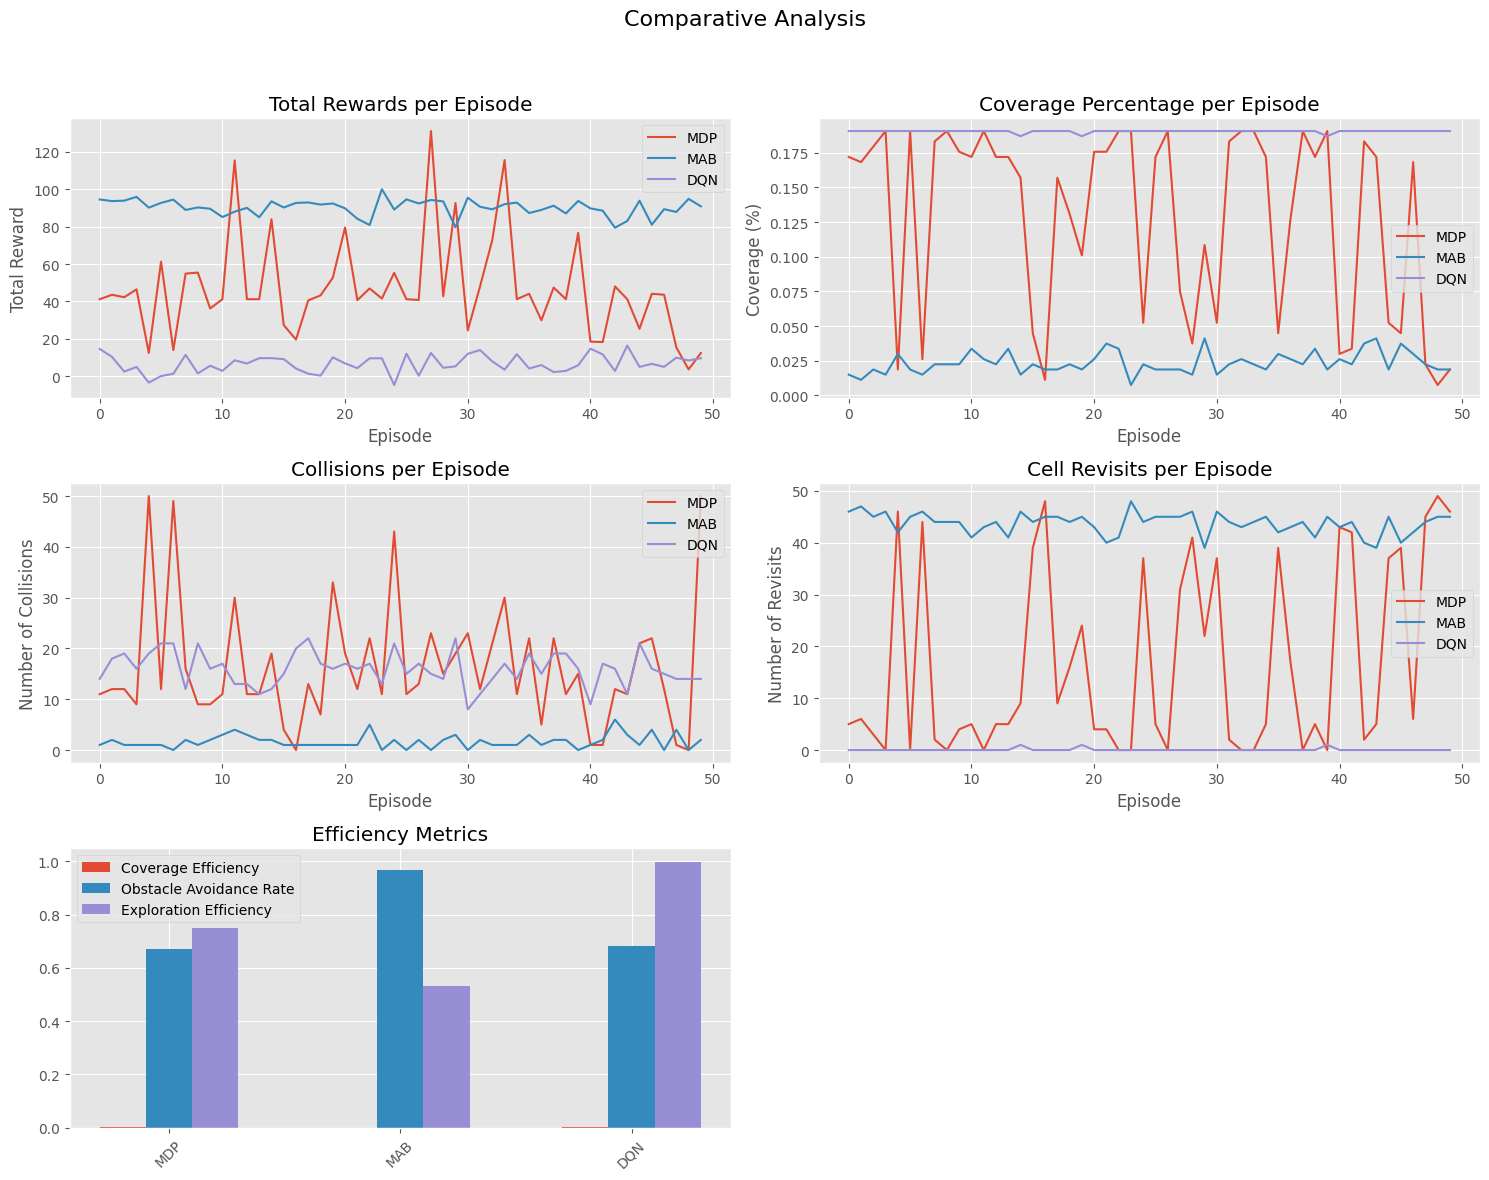

In [25]:
# Plotting
plt.style.use('ggplot')

# Create a 3x2 subplot layout (last cell will be empty)
fig, axs = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle("Comparative Analysis", fontsize=16)

# Plot 1: Total Rewards per Episode
axs[0, 0].set_title("Total Rewards per Episode")
for name, (total_rewards, _, _, _) in results.items():
    axs[0, 0].plot(total_rewards, label=name)
axs[0, 0].set_xlabel("Episode")
axs[0, 0].set_ylabel("Total Reward")
axs[0, 0].legend()

# Plot 2: Coverage Percentage per Episode
axs[0, 1].set_title("Coverage Percentage per Episode")
for name, (_, coverages, _, _) in results.items():
    axs[0, 1].plot(coverages, label=name)
axs[0, 1].set_xlabel("Episode")
axs[0, 1].set_ylabel("Coverage (%)")
axs[0, 1].legend()

# Plot 3: Collisions per Episode
axs[1, 0].set_title("Collisions per Episode")
for name, (_, _, collisions, _) in results.items():
    axs[1, 0].plot(collisions, label=name)
axs[1, 0].set_xlabel("Episode")
axs[1, 0].set_ylabel("Number of Collisions")
axs[1, 0].legend()

# Plot 4: Cell Revisits per Episode
axs[1, 1].set_title("Cell Revisits per Episode")
for name, (_, _, _, revisits) in results.items():
    axs[1, 1].plot(revisits, label=name)
axs[1, 1].set_xlabel("Episode")
axs[1, 1].set_ylabel("Number of Revisits")
axs[1, 1].legend()

# Plot 5: Bar Charts (Coverage Efficiency, Obstacle Avoidance Rate, Exploration Efficiency)
bar_width = 0.2
x = np.arange(len(results))
axs[2, 0].set_title("Efficiency Metrics")
axs[2, 0].bar(x - bar_width, [efficiency_metrics[name]['Coverage Efficiency'] for name in results], bar_width, label='Coverage Efficiency')
axs[2, 0].bar(x, [efficiency_metrics[name]['Obstacle Avoidance Rate'] for name in results], bar_width, label='Obstacle Avoidance Rate')
axs[2, 0].bar(x + bar_width, [efficiency_metrics[name]['Exploration Efficiency'] for name in results], bar_width, label='Exploration Efficiency')
axs[2, 0].set_xticks(x)
axs[2, 0].set_xticklabels(list(results.keys()), rotation=45)
axs[2, 0].legend()

# Hide the last subplot
axs[2, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
